#### REF
* https://github.com/dmlc/gluon-nlp/blob/master/docs/api/notes/data_api.rst

## Data Loading

In [17]:
import os
import pandas as pd
import numpy as np
import nltk
import collections
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score, auc
from mxnet import gluon


import time, re
import multiprocessing as mp
import itertools
from tqdm import tqdm, tqdm_notebook
import mxnet as mx
import spacy
os.environ['MXNET_ENGINE_TYPE'] = 'NaiveEngine'

### Another Data preparation
* Input data shape::$ (batch \times word \times vocab )$ 
* Split data: training & validation
* Create data iterator for training

In [18]:
MAX_SENTENCE_LENGTH = 20
MAX_VOCAB = 10000

In [19]:
nlp = spacy.load("en")

word_freq = collections.Counter()
max_len = 0
num_rec = 0
print('Count words and build vocab...')
with open('../data/umich-sentiment-train.txt', 'rb') as f:
    for line in f:
        _lab, _sen = line.decode('utf8').strip().split('\t')
        words = [token.lemma_ for token in nlp(_sen) if token.is_alpha] # Stop word제거 안한 상태 
        # 제거를 위해 [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]
        if len(words) > max_len:
            max_len = len(words)
        for word in words:
            word_freq[word] += 1
        num_rec += 1

# most_common output -> list
word2idx = {x[0]: i+2 for i, x in enumerate(word_freq.most_common(MAX_VOCAB - 2))}
word2idx ['PAD'] = 0
word2idx['UNK'] = 1

idx2word= {i:v for v, i in word2idx.items()}
vocab_size = len(word2idx)

print('Prepare data...')
y = []
x = []
origin_txt = []
with open('../data/umich-sentiment-train.txt', 'rb') as f:
    for line in f:
        _label, _sen = line.decode('utf8').strip().split('\t')
        origin_txt.append(_sen)
        y.append(int(_label))
        words = [token.lemma_ for token in nlp(_sen) if token.is_alpha] # Stop word제거 안한 상태
        words = [x for x in words if x != '-PRON-'] # '-PRON-' 제거
        _seq = []
        for word in words:
            if word in word2idx.keys():
                _seq.append(word2idx[word])
            else:
                _seq.append(word2idx['UNK'])
        if len(_seq) < MAX_SENTENCE_LENGTH:
            _seq.extend([0] * ((MAX_SENTENCE_LENGTH) - len(_seq)))
        else:
            _seq = _seq[:MAX_SENTENCE_LENGTH]
        x.append(_seq)

pd.DataFrame(y, columns = ['yn']).reset_index().groupby('yn').count().reset_index()

/opt/venv/lib/python3.6/site-packages/msgpack_numpy.py:84: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dtype=np.dtype(descr)).reshape(obj[b'shape'])
/opt/venv/lib/python3.6/site-packages/msgpack_numpy.py:88: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dtype=np.dtype(descr))[0]


Count words and build vocab...
Prepare data...


,yn,index
0,0,3091
1,1,3995


In [20]:
## Data process - tr/va split and define iterator

tr_idx = np.random.choice(range(len(x)), int(len(x) * .8))
va_idx = [x for x in range(len(x)) if x not in tr_idx]

tr_x = [x[i] for i in tr_idx]
tr_y = [y[i] for i in tr_idx]
va_x = [x[i] for i in va_idx]
va_y = [y[i] for i in va_idx]

batch_size = 16

train_data = mx.io.NDArrayIter(data=[tr_x, tr_y], batch_size=batch_size, shuffle = False)
valid_data = mx.io.NDArrayIter(data=[va_x, va_y], batch_size=batch_size, shuffle = False)

In [21]:
from mxnet import gluon, autograd, nd
from mxnet.gluon import nn, rnn
import mxnet as mx
context = mx.gpu()

### Parameters

In [22]:
learning_rate = .0002
log_interval = 100
emb_dim = 100 # Emb dim
hidden_dim = 30 # Hidden dim for LSTM

In [30]:
class Sentence_Representation(nn.Block):
    def __init__(self, EMB_DIM, HIDDEN_DIM, VOCAB_SIZE, dropout = .2, **kwargs):
        super(Sentence_Representation, self).__init__(**kwargs)
        self.VOCAB_SIZE = VOCAB_SIZE
        self.EMB_DIM = EMB_DIM
        self.HIDDEN_DIM = HIDDEN_DIM
        with self.name_scope():
            self.hidden = []
            self.embed = nn.Embedding(VOCAB_SIZE, EMB_DIM)
            self.lstm = rnn.LSTM(HIDDEN_DIM // 2, num_layers= 2, dropout = dropout, input_size = EMB_DIM, bidirectional=True)
            self.drop = nn.Dropout(.2)

    def forward(self, x, hidden):
        #print('x = {}'.format(x))
        embeds = self.embed(x) # batch * time step * embedding: NTC
        lstm_out, self.hidden = self.lstm(nd.transpose(embeds, (1, 0, 2)), hidden) #TNC로 변환
        _hid = [nd.transpose(x, (1, 0, 2)) for x in self.hidden]
        print('_hid len = {}'.format(len(_hid)))
        # Concatenate depreciated. use concat. input list of tensors
        _hidden = nd.concat(*_hid)
        return lstm_out, self.hidden

    def begin_state(self, *args, **kwargs):
        return self.lstm.begin_state(*args, **kwargs)

In [57]:
class SA_Classifier(nn.Block):
    def __init__(self, sen_rep, classifier, batch_size, context, **kwargs):
        super(SA_Classifier, self).__init__(**kwargs)
        self.batch_size = batch_size
        self.context = context
        with self.name_scope():
            self.sen_rep = sen_rep
            self.classifier = classifier
            
    def forward(self, x):
        hidden = self.sen_rep.begin_state(func = mx.nd.zeros, batch_size = self.batch_size, ctx = self.context)
        print('hidden shape = {}'.format([x.shape for x in hidden]))
        #_x, _ = self.sen_rep(x, hidden)
        _, _x = self.sen_rep(x, hidden) # Use the last hidden step
        print('x shape = {}'.format(_x[0].shape))
        x = nd.reshape(x, (-1,))
        print('xaa = {}'.format(_x[1].shape))
        x = self.classifier(x)
        return x           

In [58]:
z = nd.array([np.arange(MAX_SENTENCE_LENGTH), np.arange(MAX_SENTENCE_LENGTH) + 10], ctx= context)
print(z.shape)
sen_rep = Sentence_Representation(emb_dim, hidden_dim, MAX_VOCAB)
sen_rep.collect_params().initialize(mx.init.Xavier(), ctx = context)
sa = SA_Classifier(sen_rep, classifier, 2, context)
#sa.collect_params().initialize(mx.init.Xavier(), ctx = context)
print(sa(z))
trainer = gluon.Trainer(sa.collect_params(), 'adam', {'learning_rate': 1e-3})

(2, 20)
hidden shape = [(4, 2, 15), (4, 2, 15)]
_hid len = 2
x shape = (4, 2, 15)
xaa shape = (4, 2, 15)
xaa = (4, 2, 15)


MXNetError: Shape inconsistent, Provided = [16,30], inferred shape=(16,1)

In [10]:
sen_rep = Sentence_Representation(emb_dim, hidden_dim, MAX_VOCAB)
sen_rep.collect_params().initialize(mx.init.Xavier(), ctx = context)

classifier = nn.Sequential()
classifier.add(nn.Dense(16, activation = 'relu'))
classifier.add(nn.Dense(8, activation = 'relu'))
classifier.add(nn.Dense(1))

In [11]:
emb_dim = 50 # Emb dim
hidden_dim = 30 # Hidden dim for LSTM
sa = SA_Classifier(sen_rep, classifier,  batch_size, context)
sa.collect_params().initialize(mx.init.Xavier(), ctx = context)
loss = gluon.loss.SigmoidBCELoss()
trainer = gluon.Trainer(sa.collect_params(), 'adam', {'learning_rate': 1e-3})

/opt/venv/lib/python3.6/site-packages/mxnet/gluon/parameter.py:320: UserWarning: Parameter sentence_representation1_embedding0_weight is already initialized, ignoring. Set force_reinit=True to re-initialize.
  "Set force_reinit=True to re-initialize."%self.name)
/opt/venv/lib/python3.6/site-packages/mxnet/gluon/parameter.py:320: UserWarning: Parameter sentence_representation1_lstm0_l0_i2h_weight is already initialized, ignoring. Set force_reinit=True to re-initialize.
  "Set force_reinit=True to re-initialize."%self.name)
/opt/venv/lib/python3.6/site-packages/mxnet/gluon/parameter.py:320: UserWarning: Parameter sentence_representation1_lstm0_l0_h2h_weight is already initialized, ignoring. Set force_reinit=True to re-initialize.
  "Set force_reinit=True to re-initialize."%self.name)
/opt/venv/lib/python3.6/site-packages/mxnet/gluon/parameter.py:320: UserWarning: Parameter sentence_representation1_lstm0_l0_i2h_bias is already initialized, ignoring. Set force_reinit=True to re-initialize.

In [12]:
def evaluate(net, dataIterator, context):
    dataIterator.reset()
    loss = gluon.loss.SigmoidBCELoss()
    total_L = 0.0
    total_sample_num = 0
    total_correct_num = 0
    start_log_interval_time = time.time()
    for i, batch in enumerate(dataIterator):
        data =  batch.data[0].as_in_context(context)
        label = batch.data[1].as_in_context(context)
        output = net(data)
        L = loss(output, label)
        pred = (output > 0.5).reshape((-1,))
        #print('cor = {}'.format(pred == label))
        total_L += L.sum().asscalar()
        total_sample_num += len(label)
        total_correct_num += (pred == label).sum().asscalar()
        #print('total_correct_num = {}, total_correct_num = {}'.format(total_correct_num, total_sample_num))
        if (i + 1) % log_interval == 0:
            print('[Batch {}/{}] elapsed {:.2f} s'.format(
                i + 1, dataIterator.num_data//dataIterator.batch_size,
                time.time() - start_log_interval_time))
            start_log_interval_time = time.time()
    avg_L = total_L / float(total_sample_num)
    acc = total_correct_num / float(total_sample_num)
    return avg_L, acc

In [13]:
n_epoch = 5
for epoch in tqdm_notebook(range(n_epoch), desc = 'epoch'):
    ## Training
    train_data.reset()
    # Epoch training stats
    start_epoch_time = time.time()
    epoch_L = 0.0
    epoch_sent_num = 0
    epoch_wc = 0
    # Log interval training stats
    start_log_interval_time = time.time()
    log_interval_wc = 0
    log_interval_sent_num = 0
    log_interval_L = 0.0
    
    for i, batch in enumerate(train_data):
        _data = batch.data[0].as_in_context(context)
        _label = batch.data[1].as_in_context(context)
        L = 0
        wc = len(_data)
        log_interval_wc += wc
        epoch_wc += wc
        log_interval_sent_num += _data.shape[1]
        epoch_sent_num += _data.shape[1]
        with autograd.record():
            _out = sa(_data)
            L = L + loss(_out, _label).mean().as_in_context(context)
        L.backward()
        trainer.step(_data.shape[0])
        log_interval_L += L.asscalar()
        epoch_L += L.asscalar()
        if (i + 1) % log_interval == 0:
            tqdm.write('[Epoch {} Batch {}/{}] elapsed {:.2f} s, \
                    avg loss {:.6f}, throughput {:.2f}K wps'.format(
                    epoch, i + 1, train_data.num_data//train_data.batch_size,
                    time.time() - start_log_interval_time,
                    log_interval_L / log_interval_sent_num,
                    log_interval_wc / 1000 / (time.time() - start_log_interval_time)))
            # Clear log interval training stats
            start_log_interval_time = time.time()
            log_interval_wc = 0
            log_interval_sent_num = 0
            log_interval_L = 0
    end_epoch_time = time.time()
    test_avg_L, test_acc = evaluate(sa, valid_data, context)
    tqdm.write('[Epoch {}] train avg loss {:.6f}, valid acc {:.2f}, \
        valid avg loss {:.6f}, throughput {:.2f}K wps'.format(
        epoch, epoch_L / epoch_sent_num,
        test_acc, test_avg_L, epoch_wc / 1000 /
        (end_epoch_time - start_epoch_time)))

[Epoch 0 Batch 100/354] elapsed 2.36 s,                     avg loss 0.012871, throughput 0.68K wps
[Epoch 0 Batch 200/354] elapsed 2.28 s,                     avg loss 0.003748, throughput 0.70K wps
[Epoch 0 Batch 300/354] elapsed 2.28 s,                     avg loss 0.001471, throughput 0.70K wps
[Batch 100/199] elapsed 1.33 s
[Batch 200/199] elapsed 1.33 s
[Epoch 0] train avg loss 0.005285, valid acc 0.98,         valid avg loss 0.068408, throughput 0.70K wps
[Epoch 1 Batch 100/354] elapsed 2.28 s,                     avg loss 0.000699, throughput 0.70K wps
[Epoch 1 Batch 200/354] elapsed 2.32 s,                     avg loss 0.000474, throughput 0.69K wps
[Epoch 1 Batch 300/354] elapsed 2.27 s,                     avg loss 0.000329, throughput 0.70K wps
[Batch 100/199] elapsed 1.33 s
[Batch 200/199] elapsed 1.33 s
[Epoch 1] train avg loss 0.000528, valid acc 0.98,         valid avg loss 0.071186, throughput 0.70K wps
[Epoch 2 Batch 100/354] elapsed 2.30 s,                     avg lo

In [147]:
import numpy as np
# We need to specify batch_size explicitly becuase we need that in reshaping
idx = np.random.choice(len(va_idx), batch_size)
va_txt = [origin_txt[_idx] for _idx in va_idx]
va_txt = [va_txt[j] for j in idx]
va_txt = pd.DataFrame(va_txt, columns = ['txt'])
y_pred_sa, A = rn(nd.array([va_x[i] for i in idx], ctx = context))
pred_sa = [nd.round(val).asnumpy() for val in nd.sigmoid(y_pred_sa)] 
pred_sa_pd = pd.DataFrame(pred_sa, columns  = ['pred_sa'])
label_pd = pd.DataFrame([va_y[j] for j in idx], columns = ['label'])
result = pd.concat([va_txt, pred_sa_pd, label_pd], axis = 1)
result.head(10)

,txt,pred_sa,label
0,"Anyway, thats why I love "" Brokeback Mountain.",1.0,1
1,Combining the opinion / review from Gary and G...,0.0,0
2,we're gonna like watch Mission Impossible or H...,1.0,1
3,The Da Vinci Code sucked big time.,0.0,0
4,I am going to start reading the Harry Potter s...,1.0,1
5,I am going to start reading the Harry Potter s...,1.0,1
6,"Always knows what I want, not guy crazy, hates...",0.0,0
7,I loved this mission impossible scenario.,0.0,1
8,"I liked the first "" Mission Impossible.",1.0,1
9,Brokeback Mountain is fucking horrible..,0.0,0


In [148]:
result[result['pred_sa'] != result['label']]

,txt,pred_sa,label
7,I loved this mission impossible scenario.,0.0,1


In [149]:
import seaborn as sns
sns.set()

In [150]:
def get_attention(_att, _sentence, sentence_id):
    x = _sentence[sentence_id]
    _att = _att[sentence_id].asnumpy()
    word = []
    w_idx = []
    for token in x:
        #print(token)
        _word = idx2word[token]
        word.append(_word)
    att = pd.DataFrame(_att, index = word, columns = word)
    print(word)
    w_idx = [x for x in word if x is not 'PAD']
    print(w_idx)
    res = att.loc[w_idx][w_idx]
    return res


['i', 'hate', 'harry', 'potter', '.', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD']
['i', 'hate', 'harry', 'potter', '.']
label: 0, predicted: 0.0
['i', 'hate', 'harry', 'potter', '.', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD']
['i', 'hate', 'harry', 'potter', '.']
label: 0, predicted: 0.0
['i', 'hate', 'harry', 'potter', '.', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD

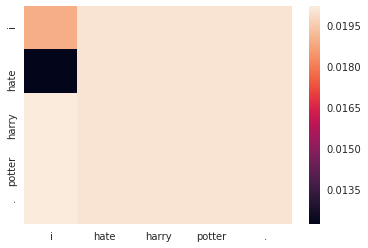

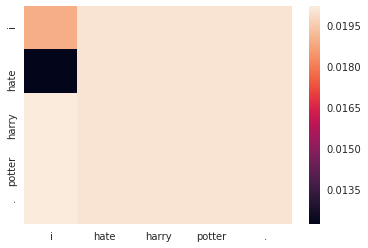

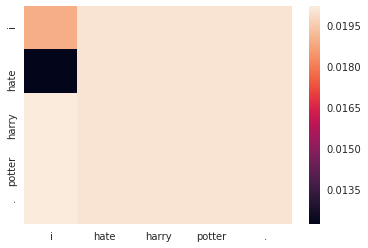

In [163]:
## Plot using Seaborn
sample_id = 10


ax = sns.heatmap(get_attention(A, [va_x[i] for i in idx], sample_id))
print('label: {}, predicted: {}'.format(result.label[sample_id], result.pred_sa[sample_id]))

In [157]:
nd.sum(A[0], axis=0)


[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]
<NDArray 50 @gpu(0)>


[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]
<NDArray 50 @gpu(0)>


[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]
<NDArray 50 @gpu(0)>

In [132]:
[va_x[i] for i in idx]

[[6,
  2,
  135,
  27,
  11,
  13,
  17,
  22,
  7,
  92,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [11,
  13,
  19,
  33,
  22,
  4,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [2,
  16,
  11,
  13,
  4,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [20,
  21,
  54,
  17,
  338,
  4,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,


In [117]:
[x for x in aa if x is not 'a']

['b', 'c']

In [121]:
aa = pd.DataFrame(A[0].asnumpy(), index = ['a' + str(i) for i in range(50)], columns = ['b' + str(i) for i in range(50)])


In [122]:
idx = ['a0', 'a1']
col = ['b0', 'b1']

In [123]:
aa.loc[idx][col]

,b0,b1
a0,0.012424,0.02
a1,0.020484,0.02


In [63]:
att = get_attention(A, [va_x[i] for i in idx], sample_id)
type(att)

NameError: name 'sample_id' is not defined

### Result

* Only 33 comments are mis-classified

In [ ]:
result[result['pred_rn'] != result['label']].shape